# Kickstarter: Classification
Tests Include:
-KNN
-Logistic Regression
-Decision Trees
-Random Forest
-SVM
-Gradient Boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import sqlalchemy
from sqlalchemy import create_engine
from flask_sqlalchemy import SQLAlchemy

from sklearn import naive_bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, auc
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import train_test_split, cross_val_predict
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import label_binarize, scale
from sklearn.multiclass import OneVsRestClassifier

import warnings
import os
%matplotlib inline

warnings.filterwarnings("ignore") #, category=DeprecationWarning)

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.5/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [2]:
# env variable at tensorflow1.4 per https://conda.io/docs/user-guide/tasks/manage-environments.html#saving-environment-variables
# and https://vsupalov.com/flask-sqlalchemy-postgres/

def get_env_variable(name):
    try:
        return os.environ[name]
    except KeyError:
        message = "Expected environment variable '{}' not set.".format(name)
        raise Exception(message)

# the values of those depend on your setup
POSTGRES_URL = get_env_variable("POSTGRES_URL")
POSTGRES_USER = get_env_variable("POSTGRES_USER")
POSTGRES_PW = get_env_variable("POSTGRES_PW")
POSTGRES_DB = get_env_variable("POSTGRES_DB")

In [3]:
DB_URL = 'postgresql+psycopg2://{user}:{pw}@{url}/{db}'.format(user=POSTGRES_USER,pw=POSTGRES_PW,url=POSTGRES_URL,db=POSTGRES_DB)

In [4]:
engine_var = DB_URL
engine = create_engine(engine_var)

In [5]:
# df = pd.read_pickle('data/kickstarter_data.pkl')
df = pd.read_sql_query('''SELECT * FROM kickstarter_data''',engine)
print(df.shape)
pd.read_sql_query('''SELECT state, main_category, main_category, currency, currency, deadline, launched, usd_goal_real, usd_pledged_real FROM kickstarter_data LIMIT 5''',engine)

(19291, 67)


,state,main_category,main_category,currency,currency,deadline,launched,usd_goal_real,usd_pledged_real
0,successful,Publishing,Publishing,USD,USD,2018-01-02,2017-12-06,2000.0,6083.00
1,successful,Music,Music,USD,USD,2018-01-02,2017-11-30,10000.0,11169.56
2,successful,Music,Music,EUR,EUR,2018-01-02,2017-11-28,30112.5,30615.02
3,successful,Music,Music,USD,USD,2018-01-02,2017-12-09,1000.0,1743.00
4,failed,Food,Food,USD,USD,2018-01-02,2017-11-03,200000.0,1.00


In [6]:
df.columns

Index(['idx', 'state_successful', 'main_category_Comics',
       'main_category_Crafts', 'main_category_Dance', 'main_category_Design',
       'main_category_Fashion', 'main_category_Film & Video',
       'main_category_Food', 'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AU', 'country_BE', 'country_CA',
       'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR',
       'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_JP',
       'country_LU', 'country_MX', 'country_NL', 'country_NO', 'country_NZ',
       'country_SE', 'country_SG', 'country_US', 'currency_CAD',
       'currency_CHF', 'currency_DKK', 'currency_EUR', 'currency_GBP',
       'currency_HKD', 'currency_JPY', 'currency_MXN', 'currency_NOK',
       'currency_NZD', 'currency_SEK', 'currency_SGD', 'currency_USD', 'ID',
       'nam

In [7]:
X = df.drop(['idx','ID','name', 'category', 'main_category', 'currency','pledged', 
             'state','country', 'usd pledged','deadline','launched','state_successful',
             'backers', 'usd_pledged_real','campaign_length','pct_goal_achieved','goal'], 1)

y = df['state_successful']

print(X.shape)
X.columns

(19291, 49)


Index(['main_category_Comics', 'main_category_Crafts', 'main_category_Dance',
       'main_category_Design', 'main_category_Fashion',
       'main_category_Film & Video', 'main_category_Food',
       'main_category_Games', 'main_category_Journalism',
       'main_category_Music', 'main_category_Photography',
       'main_category_Publishing', 'main_category_Technology',
       'main_category_Theater', 'country_AU', 'country_BE', 'country_CA',
       'country_CH', 'country_DE', 'country_DK', 'country_ES', 'country_FR',
       'country_GB', 'country_HK', 'country_IE', 'country_IT', 'country_JP',
       'country_LU', 'country_MX', 'country_NL', 'country_NO', 'country_NZ',
       'country_SE', 'country_SG', 'country_US', 'currency_CAD',
       'currency_CHF', 'currency_DKK', 'currency_EUR', 'currency_GBP',
       'currency_HKD', 'currency_JPY', 'currency_MXN', 'currency_NOK',
       'currency_NZD', 'currency_SEK', 'currency_SGD', 'currency_USD',
       'usd_goal_real'],
      dtype='object

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)

k_range = list(range(1, 201))
print(X_train.shape, y_train.shape)
print(X_test.shape,y_test.shape)

(13503, 49) (13503,)
(5788, 49) (5788,)


## K-Nearest Neighbors KNN

In [9]:
k_acc = []

for k in k_range:
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)
    knn_prediction = knn.predict(X_test)
    k_acc.append(accuracy_score(y_test, knn_prediction))

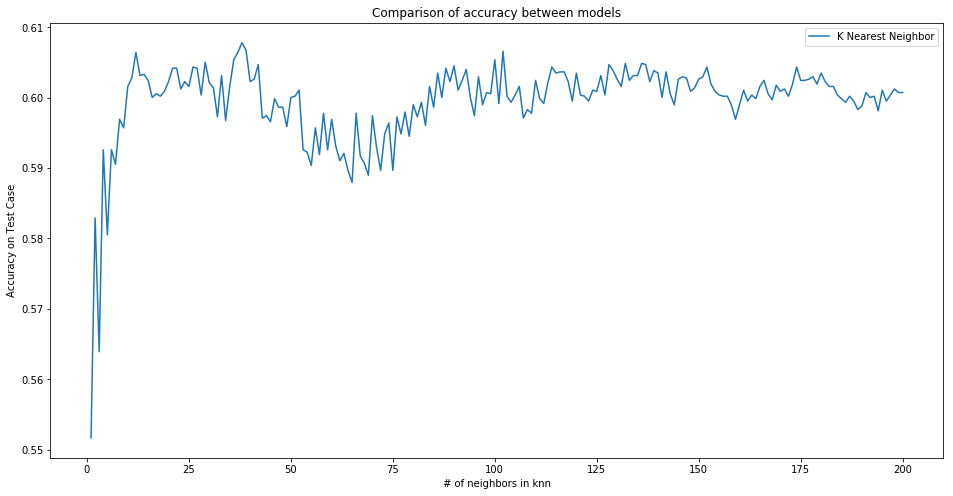

In [10]:
plt.figure(figsize=(16,8))
plt.plot(k_range, k_acc, '-', label = 'K Nearest Neighbor')
# plt.plot(k_range[np.argmax(k_acc)],k_acc)
plt.title('Comparison of accuracy between models')
plt.xlabel('# of neighbors in knn')
plt.ylabel('Accuracy on Test Case')
plt.legend(loc = 0)

In [11]:
# TO DO get top 5 k values
best_k = k_range[np.argmax(k_acc)]
best_k

38

In [12]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
print(confusion_matrix(y_test,pred))

[[2481  819]
 [1451 1037]]


In [13]:
print(classification_report(y_test,pred))

             precision    recall  f1-score   support

          0       0.63      0.75      0.69      3300
          1       0.56      0.42      0.48      2488

avg / total       0.60      0.61      0.60      5788



In [14]:
error_rate = []

# Will take some time
for k in k_range:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred_k = knn.predict(X_test)
    error_rate.append(np.mean(pred_k != y_test))

Text(0,0.5,'Error Rate')

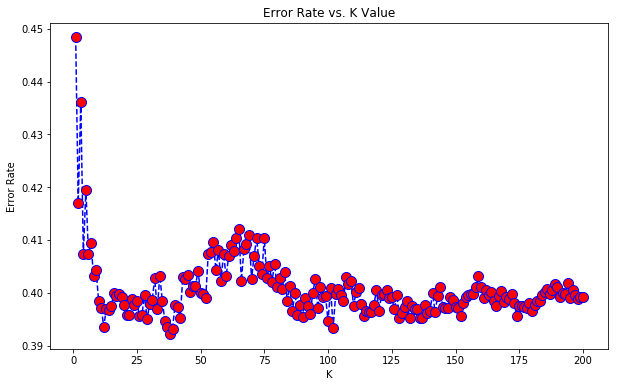

In [15]:
plt.figure(figsize=(10,6))
plt.plot(k_range,error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [16]:
knn = KNeighborsClassifier(n_neighbors=best_k)

knn.fit(X_train,y_train)
pred = knn.predict(X_test)

print('WITH Best K')
print('\n')
print(confusion_matrix(y_test,pred))
print('\n')
print(classification_report(y_test,pred))

WITH Best K


[[2481  819]
 [1451 1037]]


             precision    recall  f1-score   support

          0       0.63      0.75      0.69      3300
          1       0.56      0.42      0.48      2488

avg / total       0.60      0.61      0.60      5788



## Logistic Regression

In [17]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
predictions = logmodel.predict(X_test)

In [19]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.57      1.00      0.73      3300
          1       0.00      0.00      0.00      2488

avg / total       0.33      0.57      0.41      5788



In [20]:
## Make a logistic regression object, fit it on the training set, and test it to find accuracy
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
logistic_prediction = log_reg.predict(X_test)
log_reg_accuracy = accuracy_score(y_test, logistic_prediction)
print(log_reg_accuracy)

0.5701451278507257


In [21]:
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X, y,
                                                        cv=10, 
                                                        scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

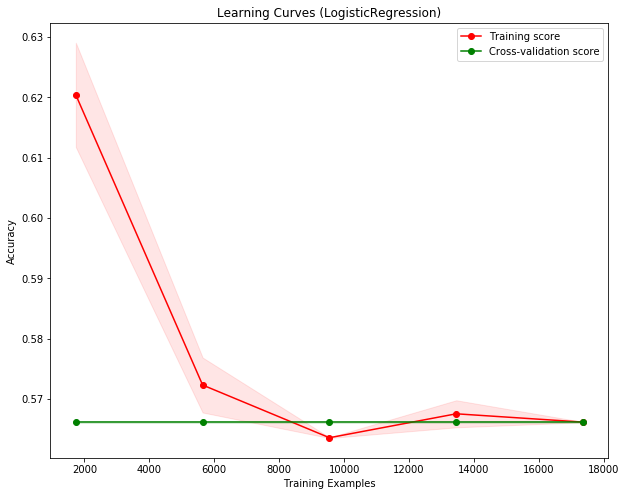

In [22]:
# Plot Training Examples vs. Accuracy
fig, ax = plt.subplots(figsize=(10, 8))

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

ax.set_title('Learning Curves (LogisticRegression)')
ax.set_xlabel('Training Examples')
ax.set_ylabel('Accuracy')
ax.legend(loc='best');

In [23]:
logreg = LogisticRegression()
log_accuracy = cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean()
log_accuracy

0.5662225928643035

In [24]:
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), 
                                                        X, y,
                                                        cv=10, 
                                                        scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

In [25]:
predictions = logmodel.predict(X_test)

In [26]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.57      1.00      0.73      3300
          1       0.00      0.00      0.00      2488

avg / total       0.33      0.57      0.41      5788



## SVM

In [27]:
svc_model = SVC()

In [28]:
svc_model.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [29]:
predictions = svc_model.predict(X_test)

In [30]:
print(confusion_matrix(y_test,predictions))

[[2551  749]
 [1597  891]]


In [31]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.61      0.77      0.69      3300
          1       0.54      0.36      0.43      2488

avg / total       0.58      0.59      0.58      5788



### GridSearchCV

In [32]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001]} 

In [33]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] gamma=1, C=0.1 ..................................................
[CV] ................................... gamma=1, C=0.1, total=   9.7s
[CV] gamma=1, C=0.1 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.1s remaining:    0.0s


KeyboardInterrupt: 

In [ ]:
grid_predictions = grid.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,grid_predictions))

In [ ]:
print(classification_report(y_test,grid_predictions))

## Decision Trees

In [ ]:
dtree = DecisionTreeClassifier()

In [ ]:
dtree.fit(X_train,y_train)

In [ ]:
predictions = dtree.predict(X_test)

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
print(confusion_matrix(y_test,predictions))

## Random Forest

In [ ]:
rfc = RandomForestClassifier(n_estimators=600)

In [ ]:
rfc.fit(X_train,y_train)

In [ ]:
predictions = rfc.predict(X_test)

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
print(confusion_matrix(y_test,predictions))

## Naive Bayes

In [ ]:
model = naive_bayes.GaussianNB()
model.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

In [ ]:
model = naive_bayes.BernoulliNB()
model.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

In [ ]:
model = naive_bayes.MultinomialNB()
model.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))


In [ ]:
X_train = scale(X_train)
X_test = scale(X_test)

model = LinearSVC()
model.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

In [ ]:
model = SVC()
model.fit(X_train, y_train)

print("Accuracy: %.3f"% accuracy_score(y_test, model.predict(X_test)))
print(classification_report(y_test, model.predict(X_test)))

## Gradient Boosting

## Ensemble

In [ ]:
model_list = [GaussianNB(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]
for model in model_list:
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X, y, 
                                                            train_sizes=[0.7],
                                                            cv=10, 
                                                            scoring='accuracy')

    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    print('%s:\n\tTest Score: Mean= %.3f, Std= %.3f\n' % (model, test_scores_mean, test_scores_std))

In [ ]:

model_list = [GaussianNB(), SVC(), DecisionTreeClassifier(), RandomForestClassifier()]
for model in model_list:
    test_scores = cross_val_score(model, X, y=y, cv=10, scoring='accuracy')
    test_scores_mean = np.mean(test_scores)
    test_scores_std = np.std(test_scores)
    
    print('%s:\n\tTest Score: Mean= %.3f, Std= %.3f\n' % (model, test_scores_mean, test_scores_std))

## Classification Errors

In [ ]:
# Define models to test
model_list = [['KNN', KNeighborsClassifier(9)], # K=9 was best performance from Challenge07
              ['Logistic', LogisticRegression()],
              ['GaussianNB', GaussianNB()], 
              ['SVC', SVC(probability=True)], 
              ['DecisionTree', DecisionTreeClassifier()], 
              ['RandomForest', RandomForestClassifier()]]

# Calculate metrics for each model
roc = {}
for model in model_list:
    
    model_name = model[0]
    model = model[1]
    
    accuracy = []
    precision = []
    recall = []
    f1 = []
    auc = []
        
    # Perform K-Fold CV and calculate metrics for each fold
    kf = KFold(5, random_state=4444, shuffle=True)
    for train_idx, test_idx in kf.split(X, y=y):
        X_train = X.iloc[train_idx, :] 
        X_test = X.iloc[test_idx, :] 
        y_train = y.iloc[train_idx] 
        y_test = y.iloc[test_idx] 
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy.append(accuracy_score(y_test, y_pred))
        precision.append(precision_score(y_test, y_pred))
        recall.append(recall_score(y_test, y_pred))
        f1.append(f1_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, y_pred))
        
    
    # Calculate mean metric across K-folds
    mean_accuracy = np.mean(accuracy)
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    mean_f1 = np.mean(f1)
    mean_auc = np.mean(auc)
    
    # Capture TPR and FPR from last fold for plotting
    y_score = model.predict_proba(X_test)[:,1]
    roc[model_name] = roc_curve(y_test, y_score)
    
    # Print formatted results
    print(model)
    print('\t==============================')
    print('\tAccuracy:', mean_accuracy)
    print('\tPrecision:', mean_precision)
    print('\tRecall:', mean_recall)
    print('\tF1:', mean_f1)
    print('\tAUC:', mean_auc)
    print('\n')

In [ ]:
# Plot the ROC curve from the last K-Fold split
fig, ax = plt.subplots(figsize=(12, 8))
colors = ['b', 'g', 'r', 'c', 'm', 'y']

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')
# Plot Classifier ROC Curves
for key, c in zip(roc.keys(), colors):
    ax.plot(roc[key][0], roc[key][1], color=c, label=key)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('Classifier Comparison')
ax.legend(loc='best');

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
# Find the weighted precision and recall
print('Weighted Precision:', precision_score(y_test, y_pred, average='weighted'))
print('Weighted Recall:', recall_score(y_test, y_pred, average='weighted'))

In [ ]:
print(classification_report(y_test, y_pred)) #, target_names=target_names))

In [ ]:
logreg = OneVsRestClassifier(LogisticRegression())
logreg.fit(X_train, y_train)
y_score = logreg.decision_function(X_test)

In [ ]:
print('Micro Average Precision:', average_precision_score(y_test, y_score, average='micro'))
print('Macro Average Precision:', average_precision_score(y_test, y_score, average='macro'))
print('Weighted Average Precision:', average_precision_score(y_test, y_score, average='weighted'))
print('Precision for each Class:', average_precision_score(y_test, y_score, average=None))

In [ ]:
precision, recall, _ = precision_recall_curve(y_test.ravel(), y_score.ravel())

In [ ]:
precision

In [ ]:
recall

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy_score(y_test, y_pred)

In [ ]:
y_score = logreg.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

# Plot 50-50 Line
ax.plot([0,1],[0,1], ls='--', color='k', label='50-50')
# Plot Logistic ROC curve
ax.plot(fpr, tpr, color='b', label='Logistic: %.3f' % roc_auc)
    
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('Logistic ROC Curve')
ax.legend(loc='best');